# __Forecast of marginal CO2 emissions: error metrics vs critical thinking!__

### Since the protflio project is performed in a research environemnt of Jupyter notebooks, we will research the effects of different features on the outcome of our forecasts here.

In [28]:
import pandas as pd
import numpy as np
import os
import datetime as dt
import joblib

import xgboost as xgb

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [29]:
file_path = '../../big_data/df_clean_interconnectors.pkl'
df = pd.read_pickle(file_path)

__It is crucial for xgboost to not encounter any NaN values. Let's see:__

In [30]:
df.isna().any()

CO2E_EMISSIONS_FACTOR    False
weekday                  False
year                     False
minute_sin               False
minute_cos               False
hour_sin                 False
hour_cos                 False
month_sin                False
month_cos                False
lag1                     False
lag2                     False
lag3                     False
lag4                     False
lag5                     False
lag6                     False
lag7                     False
lag8                     False
lag9                     False
lag10                    False
lag11                    False
lag12                    False
horizon0                 False
demand                   False
demand_capacity          False
interconnector           False
dtype: bool

In [31]:
df.shape

(920160, 25)

In [32]:
df.head()

,CO2E_EMISSIONS_FACTOR,weekday,year,minute_sin,minute_cos,hour_sin,hour_cos,month_sin,month_cos,lag1,...,lag7,lag8,lag9,lag10,lag11,lag12,horizon0,demand,demand_capacity,interconnector
2009-09-01 00:00:00,0.986067,0,2009,0.000000,1.000000e+00,0.0,1.0,-1.0,-1.836970e-16,1.032780,...,0.938327,0.912643,0.798310,0.980592,0.473708,0.971761,0.986067,1667.12,0.603199,302.86
2009-09-01 00:05:00,0.976360,0,2009,0.500000,8.660254e-01,0.0,1.0,-1.0,-1.836970e-16,0.986067,...,0.908518,0.938327,0.912643,0.798310,0.980592,0.473708,0.976360,1657.52,0.599962,300.00
2009-09-01 00:10:00,0.976889,0,2009,0.866025,5.000000e-01,0.0,1.0,-1.0,-1.836970e-16,0.976360,...,0.971761,0.908518,0.938327,0.912643,0.798310,0.980592,0.976889,1650.15,0.596877,290.52
2009-09-01 00:15:00,1.032780,0,2009,1.000000,2.832769e-16,0.0,1.0,-1.0,-1.836970e-16,0.976889,...,0.980592,0.971761,0.908518,0.938327,0.912643,0.798310,1.032780,1630.66,0.589438,260.75
2009-09-01 00:20:00,0.975655,0,2009,0.866025,-5.000000e-01,0.0,1.0,-1.0,-1.836970e-16,1.032780,...,0.903942,0.980592,0.971761,0.908518,0.938327,0.912643,0.975655,1628.96,0.587282,256.98


In [33]:
df.columns

Index(['CO2E_EMISSIONS_FACTOR', 'weekday', 'year', 'minute_sin', 'minute_cos',
       'hour_sin', 'hour_cos', 'month_sin', 'month_cos', 'lag1', 'lag2',
       'lag3', 'lag4', 'lag5', 'lag6', 'lag7', 'lag8', 'lag9', 'lag10',
       'lag11', 'lag12', 'horizon0', 'demand', 'demand_capacity',
       'interconnector'],
      dtype='object')

In [34]:
def train_validation_ts(df, relative_train, maximal_lag, horizon):
    '''
    Time series (ts) split function creates a train/test set under consideration of potential overlap between the two due to lag processing
    X_train, y_train, X_test, y_test = ...
    df=must contain target column as "target"; all other columns must be used as features
    percentage_train=how much of the total dataset shall be used for training; must be added between 0 - 1
    maximal_lag=out of all lag feature engineering, enter the maximal lag number
    '''
    k = int(df.shape[0] * relative_train)
    data_train = df.iloc[:k,:]
    #to avoid overlapping of train and test data, a gap of the maximal lag - 1 must be included between the two sets
    data_test = df.iloc[k+maximal_lag:,:]
    
    assert data_train.index.max() < data_test.index.min()
    
    #returns in the sequence X_train, y_train, X_test, y_test
    return (data_train.drop(columns=[f"horizon{horizon}","CO2E_EMISSIONS_FACTOR"], axis=1), data_train[f"horizon{horizon}"],
            data_test.drop(columns=[f"horizon{horizon}","CO2E_EMISSIONS_FACTOR"], axis=1), data_test[f"horizon{horizon}"])

In [35]:
def errors(model, X_train, y_train, X_test, y_test):

    train_mae = (sum(abs(y_train - model.predict(X_train)))/len(y_train))
    train_mape = (sum(abs((y_train - model.predict(X_train))/y_train)))*(100/len(y_train))
    train_smape = sum(abs(y_train - model.predict(X_train)))/sum(y_train + model.predict(X_train))

    test_mae = (sum(abs(y_test - model.predict(X_test)))/len(y_test))
    test_mape = (sum(abs((y_test - model.predict(X_test))/y_test)))*(100/len(y_test))
    test_smape = sum(abs(y_test - model.predict(X_test)))/sum(y_test + model.predict(X_test))

    print(f'train_MAE: {train_mae}')
    print(f'test_MAE: {test_mae}')
    
    print(f'train_MAPE: {train_mape}')
    print(f'test_MAPE: {test_mape}')
    
    print(f'train_SMAPE: {train_smape}')
    print(f'test_SMAPE: {test_smape}')

### __Training: lags (-) demand (+) interconnectors (+)__

In [36]:
df1 = df.drop(columns=["lag1", "lag2", "lag3", "lag4", "lag5", "lag6", "lag7", "lag8", "lag9", "lag10", "lag11", "lag12"])

X_train1, y_train1, X_val1, y_val1 = train_validation_ts(df1, 0.8, 12, 0)

model1 = xgb.XGBRegressor(max_depth=5,
                         learning_rate=0.1,
                         num_estimators=100,
                         n_jobs=7,
                         reg_alpha=0.05,
                         reg_lambda=0,
                        )

model1.fit(X_train1, y_train1)

errors(model1, X_train1, y_train1, X_val1, y_val1)

/home/user/venvs/dsr_teaching/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/user/venvs/dsr_teaching/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[13:22:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
train_MAE: 0.2406774219204606
test_MAE: 0.25872439834922556
train_MAPE: inf
test_MAPE: inf
train_SMAPE: 0.1709956858445325
test_SMAPE: 0.18804543241387375


__The returned errors values indicate several things to us. One thing is that our MAPE takes infinity values. As previously suggested, this is due to its nature of not being defined for any actual 0 values which are however included among our target values. Hence, instead the SMAPE is most valuable to us, especially as it - unlike MAE - provides a relative measure of our error. The SMAPE can be approximately (!) seen as the average relative deviation of our predicitons from the actual values. Therefore, our forecast is off by around 18 % from the actuals, which is reasonable for a start. Comparing the train_SMAPE and the test_SMAPE moreover indicates very moderate overfitting.__

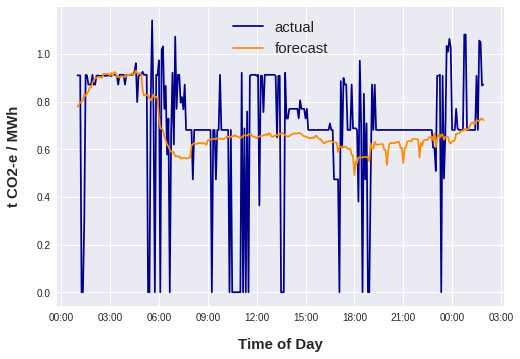

In [49]:
fig = plt.plot_date(y_val1.index[:300],y_val1.iloc[:300], linestyle='solid', marker=None, color='darkblue', label="actual")
fig = plt.plot_date(y_val1.index[:300],model1.predict(X_val1)[:300], linestyle='solid', marker=None, color='darkorange', label="forecast")
plt.legend(fontsize=15)

plt.xlabel("Time of Day", labelpad=15, fontsize=15, fontweight='bold')
plt.ylabel("t CO2-e / MWh", labelpad=15, fontsize=15, fontweight='bold')

date_format = mdates.DateFormatter('%H:%M')
plt.gca().xaxis.set_major_formatter(date_format)

plt.style.use('seaborn')

__The above figure illustrrates well how the forecast without any lagging merely catches the trend rather than the the spikes in addition to the trend.__

### __Training: lags (+) demand (-) interconnectors (-)__

In [38]:
df2 = df.drop(columns=["demand", "demand_capacity", "interconnector"])

X_train2, y_train2, X_val2, y_val2 = train_validation_ts(df2, 0.8, 12, 0)

model2 = xgb.XGBRegressor(max_depth=5,
                         learning_rate=0.1,
                         num_estimators=100,
                         n_jobs=7,
                         reg_alpha=0.05,
                         reg_lambda=0,
                        )

model2.fit(X_train2, y_train2)

errors(model2, X_train2, y_train2, X_val2, y_val2)

/home/user/venvs/dsr_teaching/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/user/venvs/dsr_teaching/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[13:22:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
train_MAE: 0.19634647785729523
test_MAE: 0.2079189048272252
train_MAPE: inf
test_MAPE: inf
train_SMAPE: 0.13949958875843474
test_SMAPE: 0.16148983467267983


__In addition to what was alredy discussed above, it can be concluded here that lagging substantially improved our forecast in terms of error metrics (!). The degree of overfitting is higher but still moderate. Whether good error metric suffice to conclude the goodness of fit, we will discuss at the bottom of this notebook!__

In [70]:
X_train.columns

Index(['weekday', 'year', 'minute_sin', 'minute_cos', 'hour_sin', 'hour_cos',
       'month_sin', 'month_cos', 'lag1', 'lag2', 'lag3', 'lag4', 'lag5',
       'lag6', 'lag7', 'lag8', 'lag9', 'lag10', 'lag11', 'lag12', 'demand',
       'demand_capacity', 'interconnector'],
      dtype='object')

In [69]:
joblib.dump(model2, '../trained_model/model2.pkl')

['../trained_model/model2.pkl']

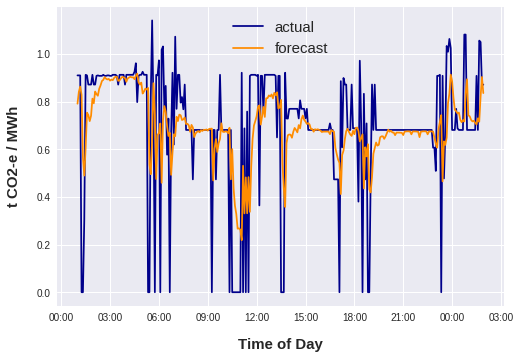

In [50]:
fig = plt.plot_date(y_val2.index[:300],y_val2.iloc[:300], linestyle='solid', marker=None, color='darkblue', label="actual")
fig = plt.plot_date(y_val2.index[:300],model2.predict(X_val2)[:300], linestyle='solid', marker=None, color='darkorange', label="forecast")
plt.legend(fontsize=15)

plt.xlabel("Time of Day", labelpad=15, fontsize=15, fontweight='bold')
plt.ylabel("t CO2-e / MWh", labelpad=15, fontsize=15, fontweight='bold')

date_format = mdates.DateFormatter('%H:%M')
plt.gca().xaxis.set_major_formatter(date_format)

plt.style.use('seaborn')

__Now that we included lagging, our prediction starts to catch up on the spikes in additon to the trend unlike above.__

### __Training lags (+) demand (+) interconnectors (-)__

In [40]:
df3 = df.drop(columns="interconnector")

X_train3, y_train3, X_val3, y_val3 = train_validation_ts(df3, 0.8, 12, 0)

model3 = xgb.XGBRegressor(max_depth=5,
                         learning_rate=0.1,
                         num_estimators=100,
                         n_jobs=7,
                         reg_alpha=0.05,
                         reg_lambda=0,
                        )

model3.fit(X_train3, y_train3)

errors(model3, X_train3, y_train3, X_val3, y_val3)

/home/user/venvs/dsr_teaching/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/user/venvs/dsr_teaching/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[13:23:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
train_MAE: 0.19614051542470323
test_MAE: 0.2077163555725931
train_MAPE: inf
test_MAPE: inf
train_SMAPE: 0.13935325194307954
test_SMAPE: 0.16126737874512465


__Including demand as a non-time series feature does not alter our pridition substantially.__

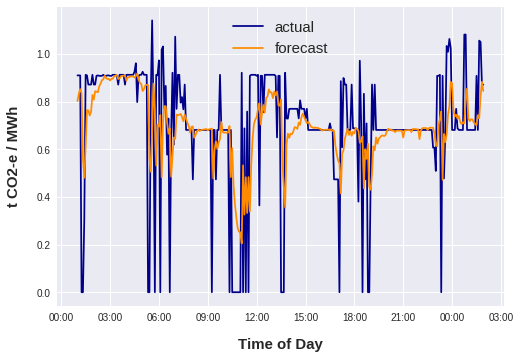

In [51]:
fig = plt.plot_date(y_val3.index[:300],y_val3.iloc[:300], linestyle='solid', marker=None, color='darkblue', label="actual")
fig = plt.plot_date(y_val3.index[:300],model3.predict(X_val3)[:300], linestyle='solid', marker=None, color='darkorange', label="forecast")
plt.legend(fontsize=15)

plt.xlabel("Time of Day", labelpad=15, fontsize=15, fontweight='bold')
plt.ylabel("t CO2-e / MWh", labelpad=15, fontsize=15, fontweight='bold')

date_format = mdates.DateFormatter('%H:%M')
plt.gca().xaxis.set_major_formatter(date_format)

plt.style.use('seaborn')

### __Training lags (+) demand (-) interconnectors (+)__

In [42]:
df4 = df.drop(columns=["demand", "demand_capacity"])

X_train4, y_train4, X_val4, y_val4 = train_validation_ts(df4, 0.8, 12, 0)

model4 = xgb.XGBRegressor(max_depth=5,
                         learning_rate=0.1,
                         num_estimators=100,
                         n_jobs=7,
                         reg_alpha=0.05,
                         reg_lambda=0,
                        )

model4.fit(X_train4, y_train4)

errors(model4, X_train4, y_train4, X_val4, y_val4)

/home/user/venvs/dsr_teaching/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/user/venvs/dsr_teaching/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[13:24:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
train_MAE: 0.1963061202823627
test_MAE: 0.2083725963713885
train_MAPE: inf
test_MAPE: inf
train_SMAPE: 0.13947091972861783
test_SMAPE: 0.16224841562813572


__Including interconnectors flow into South Australia from adjacent regions is not improving our forecasts significantly either. It even results in a mild decline of our goodness of fit.__

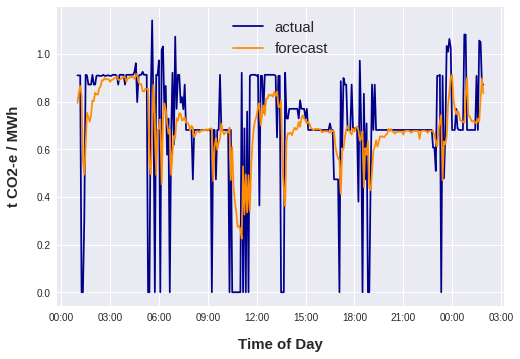

In [52]:
fig = plt.plot_date(y_val4.index[:300],y_val4.iloc[:300], linestyle='solid', marker=None, color='darkblue', label="actual")
fig = plt.plot_date(y_val4.index[:300],model4.predict(X_val4)[:300], linestyle='solid', marker=None, color='darkorange', label="forecast")
plt.legend(fontsize=15)

plt.xlabel("Time of Day", labelpad=15, fontsize=15, fontweight='bold')
plt.ylabel("t CO2-e / MWh", labelpad=15, fontsize=15, fontweight='bold')

date_format = mdates.DateFormatter('%H:%M')
plt.gca().xaxis.set_major_formatter(date_format)

plt.style.use('seaborn')

### __Training lags (+) demand (+) and interconnectors (+)__

In [44]:
X_train, y_train, X_val, y_val = train_validation_ts(df, 0.8, 12, 0)

print(X_train.columns)
print(X_val.columns)

print(X_train.index.max())
print(X_val.index.min())

model = xgb.XGBRegressor(max_depth=5,
                         learning_rate=0.1,
                         num_estimators=100,
                         n_jobs=7,
                         reg_alpha=0.05,
                         reg_lambda=0,
                        )

model.fit(X_train, y_train)

errors(model, X_train, y_train, X_val, y_val)

Index(['weekday', 'year', 'minute_sin', 'minute_cos', 'hour_sin', 'hour_cos',
       'month_sin', 'month_cos', 'lag1', 'lag2', 'lag3', 'lag4', 'lag5',
       'lag6', 'lag7', 'lag8', 'lag9', 'lag10', 'lag11', 'lag12', 'demand',
       'demand_capacity', 'interconnector'],
      dtype='object')
Index(['weekday', 'year', 'minute_sin', 'minute_cos', 'hour_sin', 'hour_cos',
       'month_sin', 'month_cos', 'lag1', 'lag2', 'lag3', 'lag4', 'lag5',
       'lag6', 'lag7', 'lag8', 'lag9', 'lag10', 'lag11', 'lag12', 'demand',
       'demand_capacity', 'interconnector'],
      dtype='object')
2016-08-30 23:55:00
2016-08-31 01:00:00


/home/user/venvs/dsr_teaching/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/user/venvs/dsr_teaching/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[13:25:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
train_MAE: 0.1960687095270836
test_MAE: 0.2078975412755377
train_MAPE: inf
test_MAPE: inf
train_SMAPE: 0.13930223810527195
test_SMAPE: 0.1614946632702779


__If we include all time features and all non-time features, the goodness of fit is about as good as including all time features while excluding all non-time features. Also overfitting occurs to the same degree.__

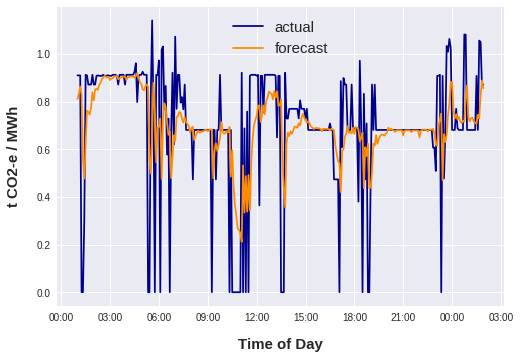

In [53]:
fig = plt.plot_date(y_val.index[:300],y_val.iloc[:300], linestyle='solid', marker=None, color='darkblue', label="actual")
fig = plt.plot_date(y_val.index[:300],model.predict(X_val)[:300], linestyle='solid', marker=None, color='darkorange', label="forecast")
plt.legend(fontsize=15)

plt.xlabel("Time of Day", labelpad=15, fontsize=15, fontweight='bold')
plt.ylabel("t CO2-e / MWh", labelpad=15, fontsize=15, fontweight='bold')

date_format = mdates.DateFormatter('%H:%M')
plt.gca().xaxis.set_major_formatter(date_format)

plt.style.use('seaborn')

### __Train / val conclusions with different features__

We could see that while the inclusion of lagging substantially improved our error metrics and resulted in catching up on the spikes, any non-time features did not contribute to any improvement of the forecast, at times it even declined the goodness of the fit.

Moreover, taking into account the visualisations from above, it appear the our forecasts struggle most catching the peaks to its full extent.

We will now perform another crucial step to interpret the outcome of our validations - zooming in!

## __Zooming in and why we have not got a forecast!__

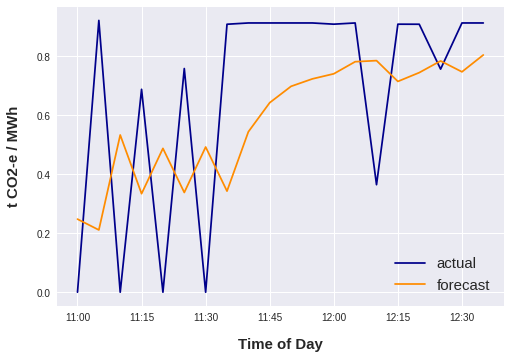

In [54]:
fig = plt.plot_date(y_val.index[120:140],y_val.iloc[120:140], linestyle='solid', marker=None, color='darkblue', label="actual")
fig = plt.plot_date(y_val.index[120:140],model.predict(X_val)[120:140], linestyle='solid', marker=None, color='darkorange', label="forecast")
plt.legend(fontsize=15)

plt.xlabel("Time of Day", labelpad=15, fontsize=15, fontweight='bold')
plt.ylabel("t CO2-e / MWh", labelpad=15, fontsize=15, fontweight='bold')

date_format = mdates.DateFormatter('%H:%M')
plt.gca().xaxis.set_major_formatter(date_format)

plt.style.use('seaborn')

__While our above forecast illustrations looked as if they forecasted trend as well as the peaks over a period of 25 h, a different picture is painted if zooming into a 80 min period. In particular when looking at the up and down peaks on the left half of the figure, it is obvious how the forecast lags behind the actuals by 5 min. I.e. if the actual goes up, the forecast does that 5 min later. Vice cersa if the actual goes down, the forecast comes down 5 min later etc. It now becomes obvious that our approach mimics any target value of a previous time point rather than performing a rela forecast.__

__This observation is further reinforced when we look at the feature importances below:__

In [58]:
def plot_feature_importances(rf, cols, model_dir):
    importances = pd.DataFrame()
    importances.loc[:, 'importances'] = rf.feature_importances_
    importances.loc[:, 'features'] = cols
    importances.sort_values('importances', inplace=True)
    f, a = plt.subplots()
    importances.plot(ax=a, kind='bar', x='features', y='importances')
    plt.gcf().subplots_adjust(bottom=0.3)
    f.savefig(os.path.join(model_dir, 'importances.png'))

In [59]:
df.head()

,CO2E_EMISSIONS_FACTOR,weekday,year,minute_sin,minute_cos,hour_sin,hour_cos,month_sin,month_cos,lag1,...,lag7,lag8,lag9,lag10,lag11,lag12,horizon0,demand,demand_capacity,interconnector
2009-09-01 00:00:00,0.986067,0,2009,0.000000,1.000000e+00,0.0,1.0,-1.0,-1.836970e-16,1.032780,...,0.938327,0.912643,0.798310,0.980592,0.473708,0.971761,0.986067,1667.12,0.603199,302.86
2009-09-01 00:05:00,0.976360,0,2009,0.500000,8.660254e-01,0.0,1.0,-1.0,-1.836970e-16,0.986067,...,0.908518,0.938327,0.912643,0.798310,0.980592,0.473708,0.976360,1657.52,0.599962,300.00
2009-09-01 00:10:00,0.976889,0,2009,0.866025,5.000000e-01,0.0,1.0,-1.0,-1.836970e-16,0.976360,...,0.971761,0.908518,0.938327,0.912643,0.798310,0.980592,0.976889,1650.15,0.596877,290.52
2009-09-01 00:15:00,1.032780,0,2009,1.000000,2.832769e-16,0.0,1.0,-1.0,-1.836970e-16,0.976889,...,0.980592,0.971761,0.908518,0.938327,0.912643,0.798310,1.032780,1630.66,0.589438,260.75
2009-09-01 00:20:00,0.975655,0,2009,0.866025,-5.000000e-01,0.0,1.0,-1.0,-1.836970e-16,1.032780,...,0.903942,0.980592,0.971761,0.908518,0.938327,0.912643,0.975655,1628.96,0.587282,256.98


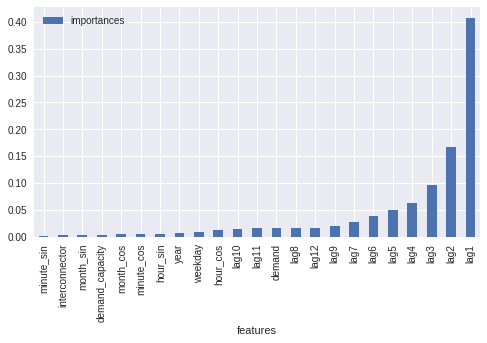

In [62]:
plot_feature_importances(model, X_train.columns.to_list(),'../images/')

In [63]:
model.feature_importances_

array([0.00866466, 0.00573979, 0.00169333, 0.00511781, 0.00556911,
       0.01181728, 0.00353194, 0.00463932, 0.40792173, 0.16736381,
       0.09642462, 0.0630556 , 0.04958121, 0.03881391, 0.02666756,
       0.01561836, 0.02004508, 0.01469472, 0.01532133, 0.01571303,
       0.01550645, 0.00373976, 0.00275959], dtype=float32)

Taking a look at the feature importances confirms what we were able to see in the 80 min visualisation interval above, namely that our presumed forecast is not a forecast but rather a mimic of the target value of the previous time point. Specifally, it is apparent from the feature importance of lag 1 which is by far the highest of all. Hypothetically, if all lags forming a sequence of previous target values would contribbute to any forecasting, then all of them would exhibit about the same feature importance.